# Machine Learning Engineer Nanodegree
## Capstone Project: Forecasting Stock Price Movement Direction

The objective of this project is *to predict whether the close price of S&P 500 today will be higher or lower than yesterday*. It is formed as binary classification problem with output be '1' if S&P 500 close is predicted to be higher than yesterday, '0' otherwise. Several supervised learning classification techniques is used to address the objective, namely Decision Tree, Logistic Regression, Support Vector Machine and Multilayer Perceptron (MLP) Neural Network. The input data to the classifier is the stock price of major world indices, while the output is the predicted trend of S&P 500. The performance of these classification models is compared to select the best model.

After the classification model has been trained, its predicted output is used to generate buy/sell signals in a customized trading strategy that trades S&P 500. The performance of the proposed trading strategy is benchmarked against a low risk buy-and-hold strategy of S&P 500. The trading strategy based on the prediction outcomes could be consider success if its portfolio return is higher compared with buy-and-hold strategy.

### Import Data

In [42]:
# Import all necessary library
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'serif'
import warnings; warnings.simplefilter('ignore')
import seaborn as sns; sns.set()
import datetime as dt
%matplotlib inline
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report,make_scorer,f1_score,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

# Set to True to retrieve data from web instead of reading from file
Get_Web_Data = False 

from util import *
from machine_learning_functions import *
from tensor_flow_functions import *

from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


For this project, 9 stock indices from 1st January 2006 to 31st December 2016 are obtained from Yahoo Finance, with 4 of them are U.S. indices, the rest of 5 are non-U.S. indices. 

|Index|Symbol|Country|Closing Time (EST)|Hours Before S&P Close|
|---|---|---|---|---|
|SPDR S&P 500 ETF Trust|SPY|U.S.|1600|0|
|Dow Jones Industrial Average|DJI|U.S.|1600|0|
|NYSE Composite Index Revised|NYA|U.S.|1600|0|
|NASDAQ Composite|IXIC|U.S.|1600|0|
|London FTSE|FTSE|U.K.|1130|4.5|
|Frankfurt DAX |GDAXI|Germany|1130|4.5|
|Tokyo Nikkei|N225|Japan|0200|14|
|Hang Seng|HSI|Hong Kong|0400|12|
|All Ordinaries|AORD|Australia|0200|14|


In [5]:
# Set the start and end date of the data set
start_date = dt.datetime(2006, 1, 1)
end_date = dt.datetime(2016, 12, 31)

if Get_Web_Data == True:
    # List the symbols of the stock indices to be retrieved
    symbol_dict = {
            'SPY' : 'SPDR S&P 500 ETF Trust',
            '^DJI': 'Dow Jones Industrial Average',
            '^NYA': 'NYSE Composite Index Revised',
            '^IXIC': 'NASDAQ Composite',
            '^FTSE': 'London FTSE',
            '^GDAXI':'Germany DAX',        
            '^N225': 'Tokyo Nikkei',
            '^HSI': 'Hong Kong Hang Seng',
            '^AORD': 'Australia All Ordinaries'
            }

    symbols, names = np.array(list(symbol_dict.items())).T
    
    # Get the data from the web
    for symbol in symbols:
        get_stock_indices_web(symbol,start_date,end_date)
        
else:
    # List of symbols to match the files name
    symbols = ['SPY','DJI','NYA','IXIC','FTSE','GDAXI','N225','HSI','AORD']
    
# Read the adjusted close data of the stock indices from stored files     
closing_data = read_data(symbols,pd.date_range(start_date, end_date))    

### Exploratory Data Analysis
#### Closing Price

In [5]:
# Plot the adjusted closing price of major stock market indices
(closing_data/closing_data.iloc[0]).iplot(title='Adjusted Closing Price of Major Stock Market Indices')

Over the eleven-year period, SPY is obviously correlated with other indices. It is noticeable that financial crisis in 2009 caused sudden drops in SPY also happened globally to all indices

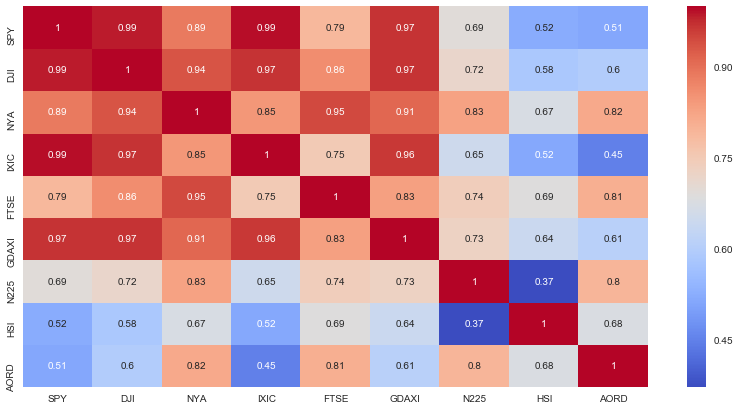

In [13]:
# Plot the correlation heatmap of the closing prices
plt.figure(figsize=(14, 7))
sns.heatmap(closing_data.corr(),cmap='coolwarm',annot=True)

Generally, all indices are strong correlated with SPY, especially U.S. and European indices. 

#### Daily Returns

In [6]:
# Compute daily returns of stocks
daily_return_data = (closing_data/closing_data.shift(1)) -1
daily_return_data.iloc[0] = 0

In [5]:
# Plot the daily returns of the stock indices
daily_return_data.iplot(title='Daily Returns of Major Stock Market Indices')

The daily returns plot does not show any particular pattern or visible trend in the data. They tend to fluctuate randomly around zero.

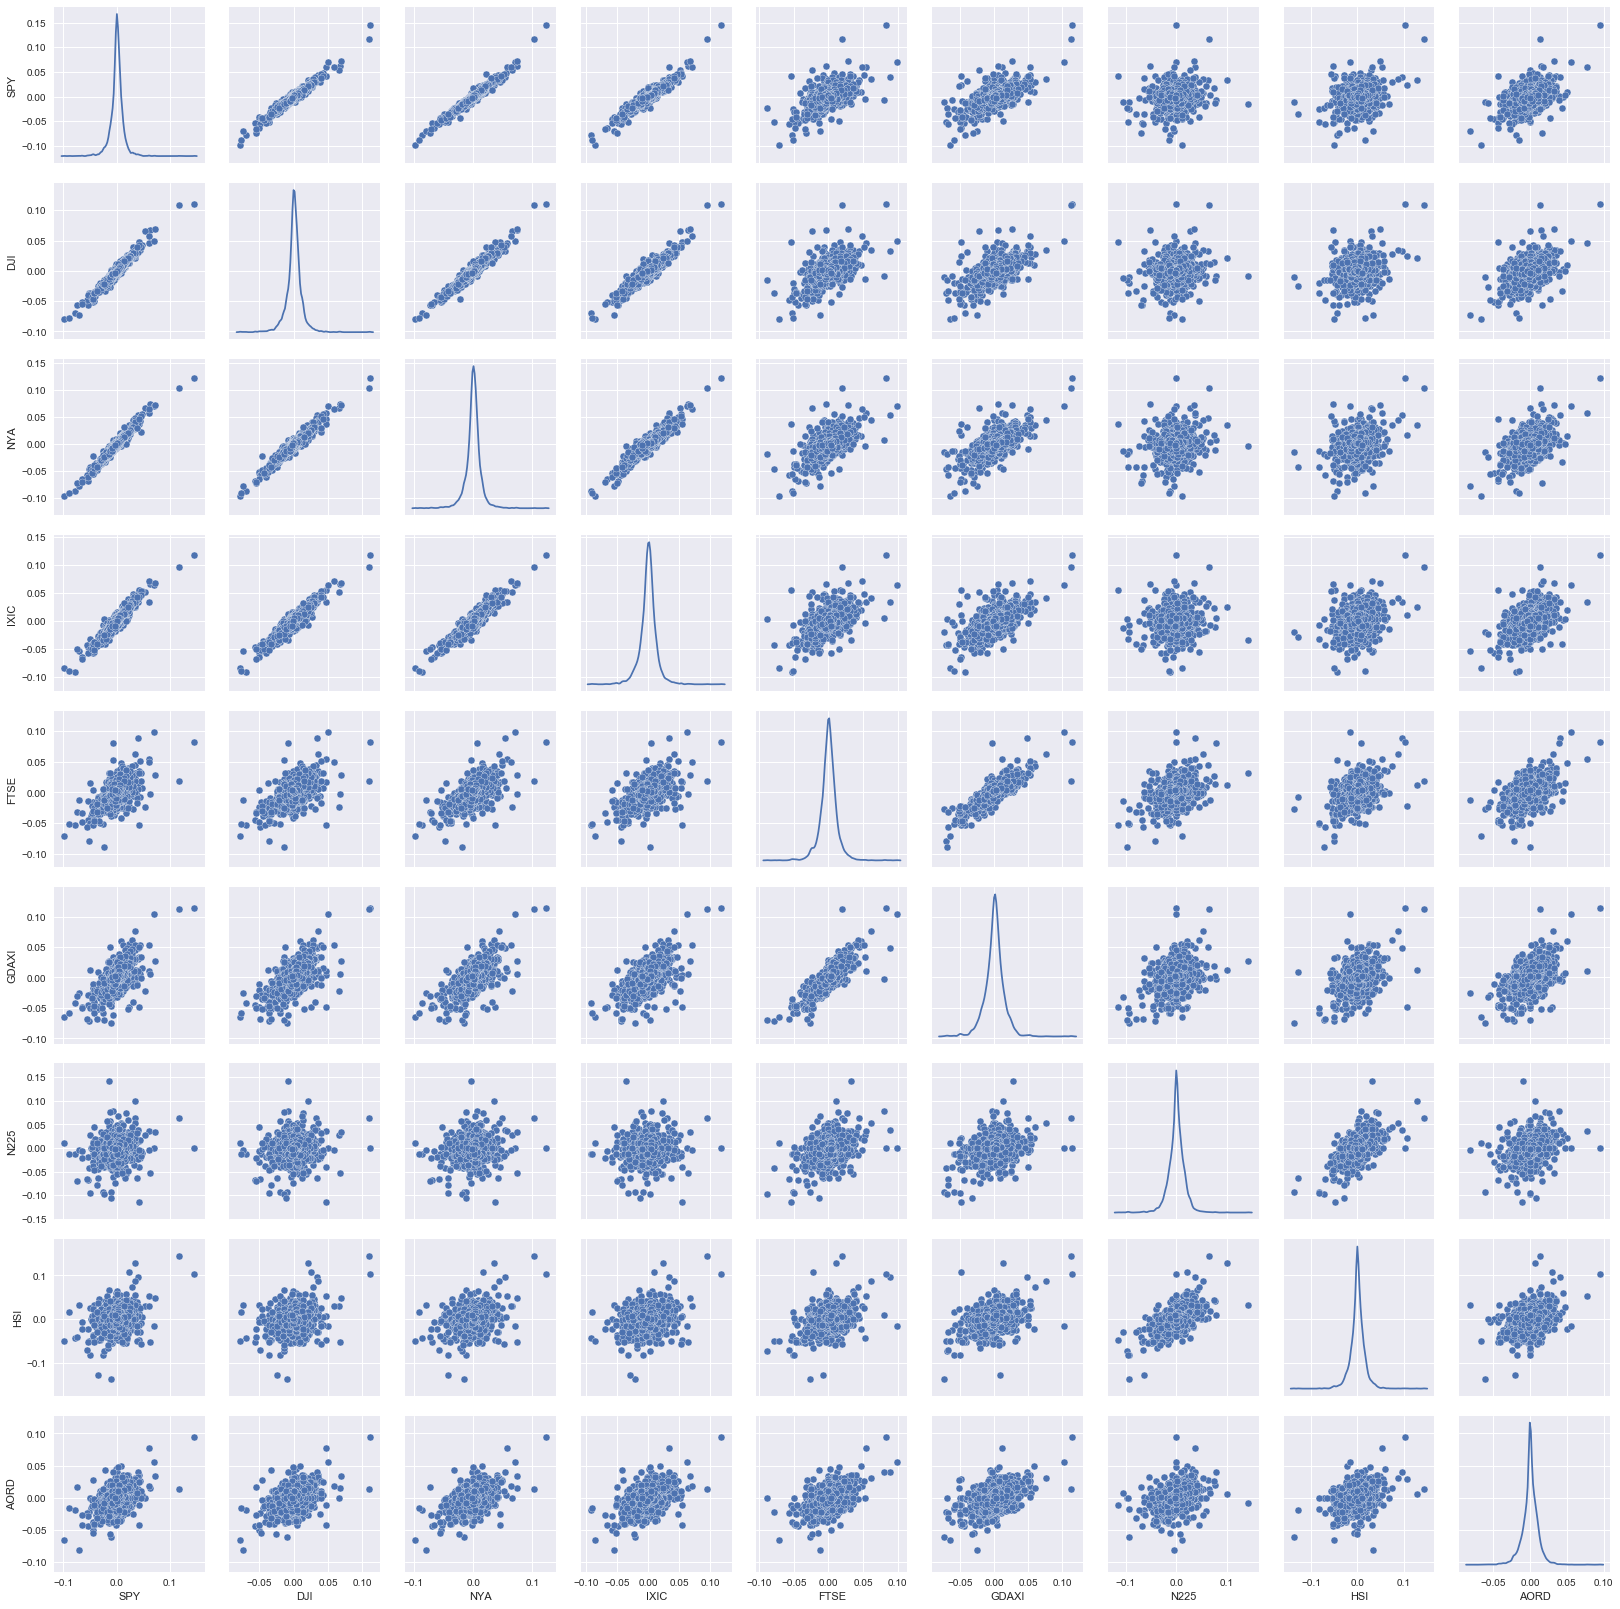

In [16]:
# Use pairplot() to get a glimpse of the pairwise relationships of the daily returns of the indices
sns.pairplot(daily_return_data,diag_kind ='kde')

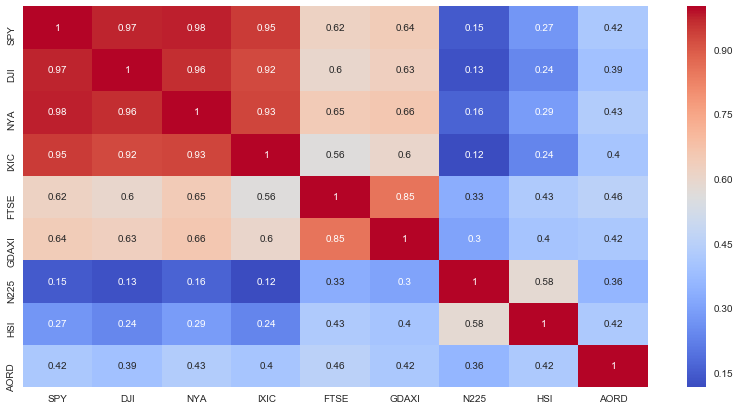

In [15]:
# Plot the heatmap of correlation of daily returns
plt.figure(figsize=(14, 7))
sns.heatmap(daily_return_data.corr(),cmap='coolwarm',annot=True)

The daily returns of U.S. indices are strongly correlated, as expected. SPY returns are correlated with European indices at around 0.62-0.64 for the FTSE and GDAXI, which is also a strong correlation. For Asian/Oceanian indices, their correlation with SPY is at around 0.15-0.42, which is a significant less correlated.

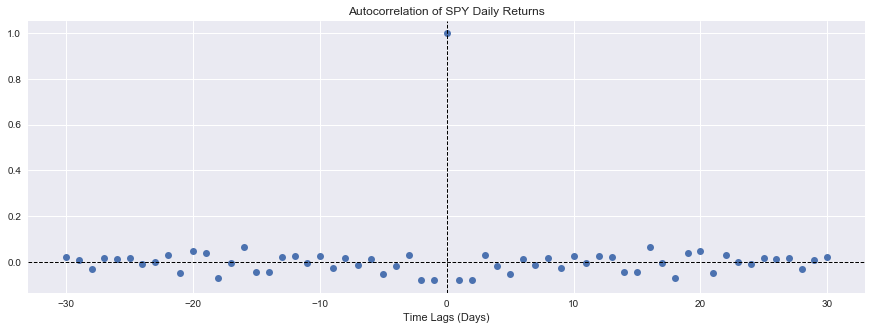

In [17]:
# Plot the autocorrelation of SPY daily returns
plt.figure(figsize=(15, 5))
plt.title('Autocorrelation of SPY Daily Returns')
plt.acorr(daily_return_data['SPY'],maxlags=30,normed=True, usevlines=False )
plt.xlabel('Time Lags (Days)')
plt.axhline(linewidth=1, color='k',linestyle='--')
plt.axvline(linewidth=1, color='k',linestyle='--')

The autocorrelations determine correlations between current values of the index and lagged values of the same index. The goal is to determine whether the lagged values are reliable indicators of the current values. It can be seen from the plot that the autocorrelation of SPY daily trend is close to zero excepts at the origin. This leads to conclusion that individual financial market is approximately a Markov process and yesterday's values are no practical help in predicting today's return.

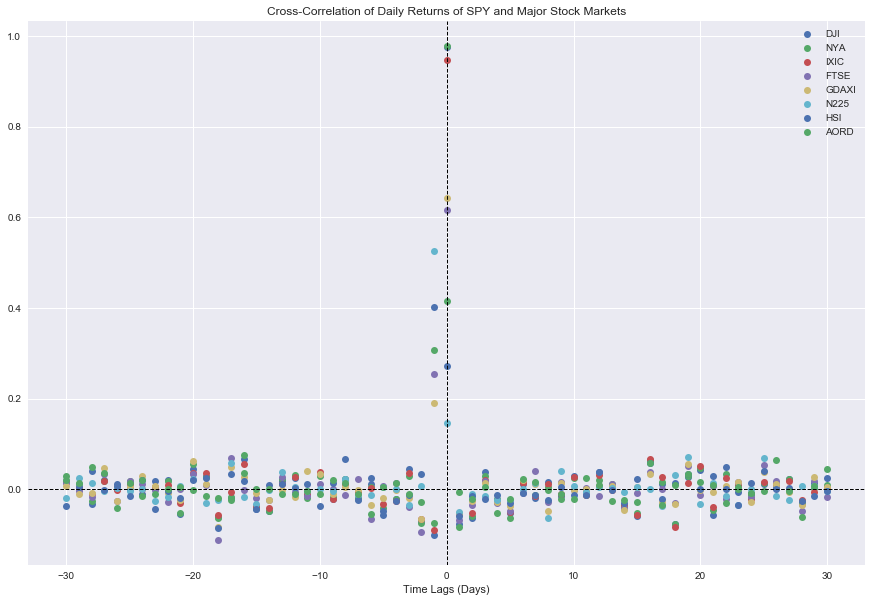

In [18]:
# Plot the cross-correlation of daily returns of SPY and other indices
plt.figure(figsize=(15, 10))
plt.title('Cross-Correlation of Daily Returns of SPY and Major Stock Markets')
for symbol in symbols[1:]:
    plt.xcorr(daily_return_data['SPY'],daily_return_data[symbol],maxlags=30,normed=True, usevlines=False,label=symbol)
plt.legend(loc='upper right')
plt.xlabel('Time Lags (Days)')
plt.axhline(linewidth=1, color='k',linestyle='--')
plt.axvline(linewidth=1, color='k',linestyle='--')

Correlation exist between SPY and other European/ Asian index values from the previous day, as shown in the plot at T-1. Other than that, it is safe to assume that past values of other indices are not good predictors for the SPY close because the cross-correlation values are close to zeros at other time lags. 

In [7]:
# Scale the data to zero mean and unit standard deviation to be input of machine learning models
scaler = preprocessing.StandardScaler()
daily_return_data = pd.DataFrame(scaler.fit_transform(daily_return_data),index = daily_return_data.index,columns = daily_return_data.columns)

Summing up the above exploratory data analysis: 
* European indices from the same day are strong predictors for the SPY daily returns. 
* Asian/Oceanian indices from the same day are significant predictors for the SPY daily returns. 
* Indices from previous days are not good predictors for the SPY daily returns.
    
Although U.S. indices have strong correlation with SPY daily returns, given the data are on same day, they are not available by the time they are needed for prediction. However, data sources such as European indices and some other markets are promising features for machine learning model as they have relative high correlation with SPY at the origin and their data is available before or at the beginning of the U.S. market trading time. This observation corroborates the previous belief about the inter-connection between global markets and how the information reflected by their movements can be beneficial to the prediction of U.S. stock markets.


### Principal Component Analysis 

The problem to be solved is predicting whether the close price of SPY today will be higher or lower than yesterday. It can be modeled as binary classification problem with output be '1' if the return of SPY close is positive, and '0' otherwise. For prediction of the SPY movement on day T, the input features to the machine learning models would be:
* Returns of non-U.S. indices available on day T (5 features)
* Returns of all stock indices available on day T-1 (9 features)

In [8]:
# Add non-U.S. today returns as basis features
features = daily_return_data[['FTSE','GDAXI','N225','HSI','AORD']]
# Add one previous day of stock indices returns as additional features
features = add_features(daily_return_data, features.loc[:], symbols, 1)

# Generate the output label of the predictions
output_label = pd.DataFrame()
output_label['Return Positive'] = daily_return_data['SPY'].apply(lambda x: 1 if x >= 0 else 0)
output_label['Return Negative'] = daily_return_data['SPY'].apply(lambda x: 1 if x < 0 else 0)

In [22]:
#Apply PCA by fitting the data with the number of dimensions as features
n_components = int(features.shape[1])
pca = PCA(n_components,random_state=7).fit(features.loc['2006-01-01':'2015-01-01'])

In [23]:
# Plot the results of PCA 

x = np.arange(1, len(pca.explained_variance_ratio_.cumsum())+1)

# Create and style traces
trace0 = go.Scatter(
    x = x,
    y = pca.explained_variance_ratio_.cumsum(),
    mode = 'lines',
)

trace1 = go.Scatter(
    x=[8.5, 2],
    y=[0.2, 0.95],
    text=['n_components=7', 
          '0.92'],
    mode='text',
)

data = [trace0, trace1]

# Edit the layout
layout = {'shapes': [
      {'line': {'dash': 'dot', 'width': 1},
       'type': 'line',
       'x0': 7,
       'x1': 7,
       'y0': 0,
       'y1': 0.92},
      {'line': {'dash': 'dot', 'width': 1},
       'type': 'line',
       'x0': 0,
       'x1': 7,
       'y0': 0.92,
       'y1': 0.92}],
     'xaxis': {'range': [0, 15], 'title': 'Number of Components'},
     'title':'Cumulative Explained Variance Ratio of PCA Components',
         'showlegend': False}

fig = dict(data=data, layout=layout)

iplot(fig, filename='styled-line')

PCA is applied on the input features to reduce the dimensionality of the feature space. Cumulative explained variance ratio plot shows 92% of the data is explained by the first 7 principle components. This reduce the dimensionality of the input space of the machine learning models from 15 to just 7.

### Benchmark

The data is split in training set and test set, with all trading days from 1st January 2006 to 31st December 2014 (2268 data points) as training set, and all trading days from 1st January 2015 to 31st December 2016 (504 data points) as test set. Because the data set is a time series, the data is not shuffled prior splitting between the training and sets to avoid look-ahead bias

In [31]:
# Split the data into training and test set
X_train, y_train, X_test, y_test = get_train_test_data(features, output_label)

# Apply PCA on input features with n_components=7
X_train_pca, X_test_pca = pca_transform(X_train, X_test, n_components=7)

In [31]:
print ("Percentage of SPY closed higher in years 2006-2014 {:.2f}%".format(sum(x > 0 for x in y_train)/len(y_train)*100))

Percentage of SPY closed higher in years 2006-2014 52.80%


In [29]:
# Benchmark: Always predict SPY will close higher compared to yesterday
y_benchmark = [1]*len(y_test)

benchmark_accuracy = accuracy_score(y_test,y_benchmark)
benchmark_f1 = f1_score(y_test,y_benchmark)

print ("Benchmark accuracy {:.2f}%".format(benchmark_accuracy*100))
print ("Benchmark F1 Score {:.2f}".format(benchmark_f1))

Benchmark accuracy 48.61%
Benchmark F1 Score 0.65


Probability of SPY closed higher (daily return is positive) in years 2006-2014 is 52.80%, which is greater than the probability of SPY closed lower (daily return is negative). Based on this observation, the most naïve prediction for any given day would be that the market would increase.  If the model were to use this assumption to make prediction on the test set data, it would have an accuracy of 48.61% and an F1 Score of 0.65. These values will be served as the benchmark of accuracy and F1 Score of the machine learning models for this project.

### Supervised Learning Classification Models

Four supervised learning classifiers are chosen in this project:
* Decision Tree
* Logistic Regression
* Support Vector Machine (SVM)
* Multilayer Perceptron Neural Network (MLP)

In [12]:
# Create variables to store the metrics
estimator = {}
accuracy = np.zeros(4)
f1 = np.zeros(4)

# Train the machine learning models using default setting of sklearn
estimator[0], accuracy[0], f1[0] = train_decision_tree(X_train_pca, y_train, X_test_pca, y_test)
estimator[1], accuracy[1], f1[1] = train_logistic_regression(X_train_pca, y_train, X_test_pca, y_test)
estimator[2], accuracy[2], f1[2] = train_svm(X_train_pca, y_train, X_test_pca, y_test)

# Train the MLP
X_train, y_train, X_test, y_test = get_train_test_data(features, output_label, isTensor=True)
accuracy[3], f1[3] = train_mlp_default(X_train_pca, y_train, X_test_pca, y_test)


Epoch: 0 Accuracy= 0.5280
Epoch: 500 Accuracy= 0.6936
Epoch: 1000 Accuracy= 0.7285
Epoch: 1500 Accuracy= 0.7263
MLP Training Finished!
F1 Score = 0.6887
Accuracy = 0.7004


In [21]:
# Plot the accuracy and F1 Scores of the models
iplot({
    'data': [
        go.Bar(**{
            'x': ['Benchmark','Decision Tree','Logistic Regression','SVM','MLP'],
            'y': np.append(benchmark_accuracy, accuracy),
            'name': 'Accuracy',
            'type': 'bar'
        }),
        go.Bar(**{
            'x': ['Benchmark','Decision Tree','Logistic Regression','SVM','MLP'],
            'y': np.append(benchmark_f1, f1),
            'name': 'F1 Score',
            'type': 'bar'
        })
    ],
    'layout': go.Layout(**{
        'title':' Classification Performance of Different Machine Learning Models'
    })
})

All models exhibit accuracy and F1 scores above the benchmark values. Among these models, logistic regression, SVM and MLP perform significantly better than benchmark result with nearly a 20% improvement of accuracy compared to benchmark value.

### Refinements

Grid search cross validation (GridSearchCV via sklearn) is conducted on the decision tree, logistic regression, SVM models to improve classification performance. For MLP model, several variations of the number of network layers and number of neurons per layer are tested to find the optimal model. The model with highest accuracy and F1 Score is selected as the best classification model.

In [24]:
# Create variables to store the metrics
best_estimator = {}
best_accuracy = np.zeros(4)
best_f1 = np.zeros(4)

scorer = make_scorer(accuracy_score)  

# Split the data into training and test set
X_train, y_train, X_test, y_test = get_train_test_data(features, output_label)

# Decision tree
param_grid = {'max_depth': np.arange(3, 15),'min_samples_leaf':np.arange(5, 15)}
best_estimator[0], best_accuracy[0], best_f1[0] = grid_search(estimator[0], param_grid, scorer, X_train_pca, y_train, X_test_pca, y_test)

# Logistic regression
param_grid = {'C': np.logspace(-5, 8, 20)}
best_estimator[1], best_accuracy[1], best_f1[1] = grid_search(estimator[1], param_grid, scorer, X_train_pca, y_train, X_test_pca, y_test)

{'min_samples_leaf': 7, 'max_depth': 6}
{'C': 0.12742749857031346}


In [16]:
# SVM
param_grid = {'C': np.logspace(-5, 8, 20),'gamma':np.logspace(-5, 5, 5)}
best_estimator[2], best_accuracy[2], best_f1[2] = grid_search(estimator[2], param_grid, scorer, X_train_pca, y_train, X_test_pca, y_test)

{'gamma': 0.0031622776601683794, 'C': 2.9763514416313193}


In [17]:
# MLP
X_train, y_train, X_test, y_test = get_train_test_data(features, output_label, isTensor=True)
best_accuracy[3], best_f1[3] = train_mlp_tuned(X_train_pca, y_train, X_test_pca, y_test)

Epoch: 0 Accuracy= 0.5280
Epoch: 500 Accuracy= 0.7263
Epoch: 1000 Accuracy= 0.7263
MLP Training Finished!
F1 Score = 0.6925
Accuracy = 0.7004


In [18]:
# Plot the accuracy and F1 Scores of the models after fine-tuning
iplot({
    'data': [
        go.Bar(**{
            'x': ['Benchmark','Decision Tree','Logistic Regression','SVM','MLP'],
            'y': np.append(benchmark_accuracy, best_accuracy),
            'name': 'Accuracy',
            'type': 'bar'
        }),
        go.Bar(**{
            'x': ['Benchmark','Decision Tree','Logistic Regression','SVM','MLP'],
            'y': np.append(benchmark_f1, best_f1),
            'name': 'F1 Score',
            'type': 'bar'
        })
    ],
    'layout': go.Layout(**{
        'title':' Classification Performance of Different Machine Learning Models After Fine-tuning'
    })
})

Overall, slight performance improvement can be found on decision tree model with about 4.57% increase of accuracy and 0.0542 increase of F1 Score. For other models, there is no much changes in the accuracy and F1 Score.

Among all machine learning models, logistic regression gives the best performance in predicting index movement, whose accuracy is 70.04% and F1 Score is 0.7113. Both accuracy and F1 score outperformed benchmark values, which is simply always guessing that the market will close higher than yesterday. 

Final accuracy score on testing data: 70.04%
Final F1 Score on testing data: 0.7113


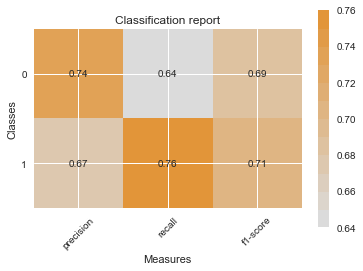

In [36]:
# Print the accuracy and F1 Score of best model
y_predict = best_estimator[1].predict(X_test_pca)

print ("Final accuracy score on testing data: {:.2f}%".format(accuracy_score(y_test['Return Positive'], y_predict)*100))
print ("Final F1 Score on testing data: {:.4f}".format(f1_score(y_test['Return Positive'], y_predict)))

# Get the classification report of best model
cr = classification_report(y_test['Return Positive'],y_predict)
plot_classification_report(cr)

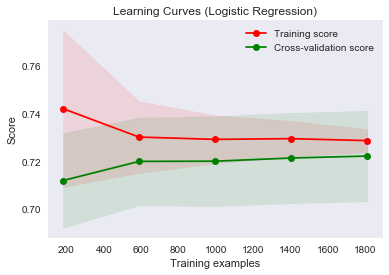

<module 'matplotlib.pyplot' from 'C:\\ProgramData\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [43]:
# Apply cross-validation on the logistic regression 

title = "Learning Curves (Logistic Regression)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = StratifiedShuffleSplit(n_splits=100, test_size=0.2)

# Plot the learning curve
plot_learning_curve(LogisticRegression(random_state=10,C=0.12742), title, X_train_pca, y_train['Return Positive'], cv=cv, n_jobs=4)


The plot reveals that adding more training data does not boost the performance significantly. Therefore, the number of training samples chosen in this project is sufficient for the problem. Both training score and cross-validation score are consistently above 0.70. The gap between training score and cross-validation score is also not significant, indicating that the model is not suffering from overfitting problem. As a result, the proposed model is an effective and robust solution for predicting the trend of stock index.

### Backtesting Trading Strategy 

The prediction results of the machine learning model are saved as a single CSV file and uploaded to Dropbox. A proposed  trading strategy which is executed on the [Quantopian](https://www.quantopian.com) web-based IDE imports the prediction results to determine buy/sell signals.

In [20]:
# Export predictions of best model to a CSV file
predictions = pd.DataFrame(y_predict, index = X_test.index, columns = ['prediction']) 
predictions['symbol'] = 'SPY'
predictions.to_csv("prediction_machine_learning.csv",date_format = '%m-%d-%y',index_label=['date'])

The proposed trading strategy starts with initial capital with $100,000 dollars and its performance is compared with buy-and-hold strategy. For buy-and-hold strategy, all initial capital is invested to purchase SPY shares on first trading day of year 2015 and the shares are held until the end of year 2016.The details of the backtesting results can be accessed on [here](https://www.quantopian.com/posts/proposed-trading-strategy) and [here](https://www.quantopian.com/posts/buy-and-hold-strategy).

The performance charts of the proposed trading strategy and buy-and-hold strategy generated by Quantopian are presented in following figures.  The red line indicates the performance of default benchmark used by Quantopian which is also a buy-and-hold but with reinvested dividends. It can be ignored in following performance analysis.

Performance of proposed trading strategy simulated on [Quantopian](https://www.quantopian.com/posts/proposed-trading-strategy): 
![alt text](https://dl.dropboxusercontent.com/s/p8sxt3b17ajsxq0/proposed_strategy.png "Proposed trading strategy")

Performance of buy-and-hold strategy simulated on [Quantopian](https://www.quantopian.com/posts/buy-and-hold-strategy):
![alt text](https://dl.dropboxusercontent.com/s/p0al22gkpp5xln4/proposed_strategy.png "Buy-and-hold strategy")

Initially, the cumulative returns of proposed strategy are lower than buy-and-hold strategy. The strengths of the proposed strategy based on prediction results becomes apparent after mid of August 2015, when the portfolio returns become positive and stays in positive after that. For buy-and-hold strategy, the portfolio returns fluctuate between positive and negative during entire test period and apparently is more volatile than proposed trading
15
strategy. At the end of test period, the SPY shares at hands based on proposed trading strategy worth $129,182 dollars, resulting in 29.2% of total returns. It is better than buy-and-hold strategy with total returns of 11.9%. Besides high profit, the proposed strategy also has the advantage of higher risk-adjusted return with Sharpe ratio of 0.60 compared with 0.46 of buy-and-hold strategy.